In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score, confusion_matrix
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine
from GraphTsetlinMachine.graphs import Graphs   

# For when not using command line arguments:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('-f') # Dummy argument

#plt.switch_backend('Agg') # Disable plots if backend not interactive

board_count = 0
board_size = 0
board_type = ""
boards = []
labels = []
label_names = ["X_win", "O_win"]

# Load dataset
with open("hex_complete_5x5_4000_barely_filled.txt") as f:
    
    board_count, board_size, empty = [int(x) for x in f.readline().split(' ')]
    
    if "barely" in f.name:
        board_type = f"Barely filled (>={empty} empty cells)"
    elif "mostly" in f.name:
        board_type = f"Mostly filled (<={empty} empty cells)"
    else: board_type = f"Randomly filled ({empty} empty cells)"

    boards = np.empty([board_count, board_size, board_size], dtype=str)
    current_board = 0
    row = 0
    
    X_count = 0
    O_count = 0
    
    for line in f:
        if line == '\n':
            continue
        if row < board_size:
            for column, char in enumerate(line.rstrip()):
                boards[current_board][row][column] = char
            row += 1
        else:
            row = 0
            
            # Count wins to see if dataset is balanced
            if int(line.rstrip()) == 0:
                X_count += 1
            else:
                O_count += 1
            
            labels.append(int(line.rstrip()))
            current_board += 1


Dataset:
Board size:  5x5
Board count: 4000
Board type:  Barely filled (>=10 empty cells)
X wins:      1993
O wins:      2007

X: Vertical   - win=0
O: Horizontal - win=1

Game 1 & 2:
[[['*' '*' '*' 'X' '*']
  ['O' '*' 'X' '*' 'X']
  ['*' 'O' 'X' 'X' 'X']
  ['*' '*' 'O' 'O' 'X']
  ['*' 'O' 'O' 'O' 'X']]

 [['*' '*' 'O' '*' 'O']
  ['*' '*' 'X' 'X' '*']
  ['*' 'X' 'X' '*' 'X']
  ['O' 'O' 'O' 'X' 'O']
  ['*' 'X' 'O' 'O' '*']]]

Game 1 & 2 Results:
[0, 1]


Initialization of sparse structure.

EPOCH 1                          Total Runtime:    23.44s
Training Accuracy:    97.97%  |  Test Accuracy:    97.88%  
Training Precision:   99.61%  |  Test Precision:   99.49%  
Training Recall:      96.31%  |  Test Recall:      96.33%  
Training F1:          97.93%  |  Test F1:          97.89%  
Training Time:      10.8081s  |  Test Time:       1.2536s

EPOCH 2                          Total Runtime:    37.08s
Training Accuracy:    99.28%  |  Test Accuracy:    99.12%  
Training Precision:   99.62%  

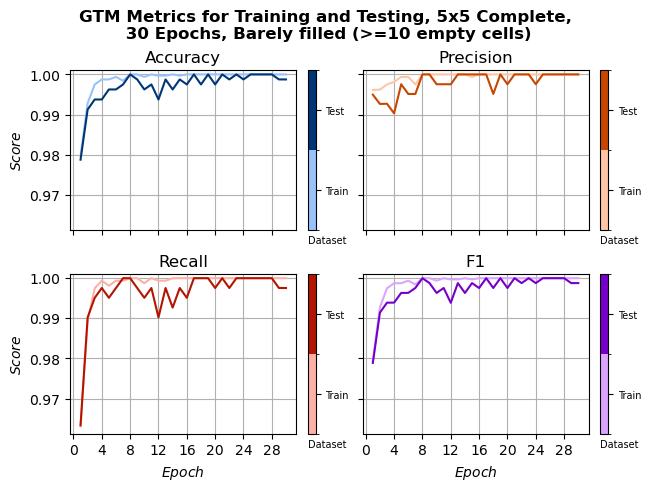

In [11]:
def plot_metrics(accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, epochs, board_size, board_type):
    # Plot accuracy, precision, recall and f1-score for training and testing
    
    dataset_types = ["Train", "Test"]
    
    x_values = np.arange(1, epochs+1, 1)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='all', constrained_layout=True)
    fig.suptitle(f'GTM Metrics for Training and Testing, {board_size}x{board_size} Complete,\n {epochs} Epochs, {board_type}', fontweight='bold')
    
    blue = [(0.6, 0.76, 0.98), (0, 0.21, 0.46)] 
    orange = [(255/255, 197/255, 165/255), (200/255, 71/255, 0/255)]
    red = [(255/255, 176/255, 165/255), (180/255, 21/255, 0/255)]
    purple = [(219/255, 165/255, 255/255), (119/255, 0/255, 200/255)]
    blue_cm = mpl.colors.LinearSegmentedColormap.from_list('custom_blue', blue, N=10)
    orange_cm = mpl.colors.LinearSegmentedColormap.from_list('custom_orange', orange, N=10)
    red_cm = mpl.colors.LinearSegmentedColormap.from_list('custom_red', red, N=10)
    purple_cm = mpl.colors.LinearSegmentedColormap.from_list('custom_purple', purple, N=10)

    colormaps = [blue_cm, orange_cm, red_cm, purple_cm]

    accuracy_colors = colormaps[0](np.linspace(0, 1, len(dataset_types)))
    precision_colors = colormaps[1](np.linspace(0, 1, len(dataset_types)))
    recall_colors = colormaps[2](np.linspace(0, 1, len(dataset_types)))
    f1_colors = colormaps[3](np.linspace(0, 1, len(dataset_types)))

    ax1.set_title('Accuracy')
    ax2.set_title('Precision')
    ax3.set_title('Recall')
    ax4.set_title('F1')
    
    for index, ax in enumerate (fig.get_axes()):
        ax.set(xlabel='$\it{Epoch}$', ylabel='$\it{Score}$')
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax.label_outer()
        ax.grid()
        
        bounds = [0, 1, 2]
        norm = mpl.colors.BoundaryNorm(bounds, colormaps[index].N)
        scalar_mappable = plt.cm.ScalarMappable(cmap=colormaps[index], norm=norm)
        
        clb = plt.colorbar(scalar_mappable, ax=ax)
        clb.ax.set_xlabel('Dataset', fontsize=7, loc='left')
        clb.ax.set_yticks([0.5, 1.5])
        clb.ax.set_yticklabels(dataset_types, fontsize=7)

    ax1.plot(x_values, accuracy_train, color=accuracy_colors[0])
    ax2.plot(x_values, precision_train, color=precision_colors[0])
    ax3.plot(x_values, recall_train, color=recall_colors[0])
    ax4.plot(x_values, f1_train, color=f1_colors[0])
    
    ax1.plot(x_values, accuracy_test, color=accuracy_colors[1])
    ax2.plot(x_values, precision_test, color=precision_colors[1])
    ax3.plot(x_values, recall_test, color=recall_colors[1])
    ax4.plot(x_values, f1_test, color=f1_colors[1])
    
    ax.set_ylim(top=1.001)
    
    fig.savefig(f"metrics_{board_size}x{board_size}_complete_{epochs}_epochs_{board_type.split(' ')[0]}.png", dpi=1200)
    fig.show()


def main():
    # Track runtime
    start_time = time()
    
    # Parameters:
    epochs = 30
    number_of_clauses = 500
    T = 1000
    s = 0.8
    depth = 3
    hypervector_size = 256
    hypervector_bits = 1
    message_size = 4096
    message_bits = 1
    max_included_literals = 16
    
    # Print info about dataset
    print(f"Dataset:\n"
      f"Board size:  {board_size}x{board_size}\n"
      f"Board count: {board_count}\n"
      f"Board type:  {board_type}\n"
      f"X wins:      {X_count}\n"
      f"O wins:      {O_count}\n"
      f"")
    
    print("X: Vertical   - win=0\n"
          "O: Horizontal - win=1\n")
    
    print("Game 1 & 2:")              
    print(boards[:2]) 
    print()
    print("Game 1 & 2 Results:")
    print(labels[:2])
    print("\n")
    
    # Split dataset
    X_train, X_test, Y_train, Y_test = train_test_split(boards, np.array(labels, dtype=np.uint32), test_size=0.20, random_state=42)


    #************************************** Initialize graphs for training data ***************************************
    graphs_train = Graphs(
        X_train.shape[0],
        symbols=['X', 'O', '*', 'Xw', 'Ow', 'Xc', 'Xs', 'Oc', 'Os'],
        hypervector_size=hypervector_size, # Number of features
        hypervector_bits=hypervector_bits
    )
    
    for graph_id in range(X_train.shape[0]):
        graphs_train.set_number_of_graph_nodes(graph_id, board_size*board_size)
    
    # Add nodes
    graphs_train.prepare_node_configuration()
    
    for graph_id in range(X_train.shape[0]):
        for i in range(board_size):
            for j in range(board_size):
                if j == 0 or j == board_size-1 or i == 0 or i == board_size-1:
                    # Along borders of board
                    if (i == 0 and j == 0) or (i == board_size-1 and j == board_size-1):
                        number_of_outgoing_edges = 2 # Top left / bottom right
                        graphs_train.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)
                    elif (i == 0 and j == board_size-1) or (i == board_size-1 and j == 0):
                        number_of_outgoing_edges = 3 # Top right / bottom left
                        graphs_train.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)
                    else:
                        number_of_outgoing_edges = 4 # Between corners
                        graphs_train.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)
                else:
                    number_of_outgoing_edges = 6 # Middle
                    graphs_train.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)


    # Add edges
    graphs_train.prepare_edge_configuration()
    
    # Add node properties and class labels
    for graph_id in range(X_train.shape[0]):
        for i in range(board_size):
            for j in range(board_size):
                graphs_train.add_graph_node_property(graph_id, f"n{i}{j}", X_train[graph_id][i][j])
                
                # Wall nodes top bottom
                if i == 0 or i == board_size-1:
                    graphs_train.add_graph_node_property(graph_id, f"n{i}{j}", 'Xw')
                    
                # Wall nodes left right
                if j == 0 or j == board_size-1:
                    graphs_train.add_graph_node_property(graph_id, f"n{i}{j}", 'Ow')
                    
                    
    for graph_id in range(X_train.shape[0]):
        for i in range(board_size):
            for j in range(board_size):
                # Specify edge between nodes as a "chain" if it connects two pieces of the same type
                chained = 0
                if j != board_size-1:
                    if X_train[graph_id][i][j+1] == X_train[graph_id][i][j] != '*':
                        # Right neighbour of same type
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j+1}", f"right_{X_train[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        # Attempt to dynamically adjust number of node edges
                        # num = graphs_train.number_of_graph_node_edges[graphs_train.node_index[graph_id] + graphs_train.graph_node_id[graph_id][f'n{i}{j}']]
                        # graphs_train.number_of_graph_node_edges[graphs_train.node_index[graph_id] + graphs_train.graph_node_id[graph_id][f'n{i}{j}']] = num - 1
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j+1}", "right") # Right
                
                if i != board_size-1:
                    if X_train[graph_id][i+1][j] == X_train[graph_id][i][j] != '*':
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j}", f"down_right_{X_train[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j}", "down_right") # Down-right
                    
                if j != 0 and i != board_size-1:
                    if X_train[graph_id][i+1][j-1] == X_train[graph_id][i][j] != '*':
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j-1}", f"down_left_{X_train[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j-1}", "down_left") # Down-left
                    
                if j != 0:
                    if X_train[graph_id][i][j-1] == X_train[graph_id][i][j] != '*':
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j-1}", f"left_{X_train[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j-1}", "left") # Left
                    
                if i != 0:
                    if X_train[graph_id][i-1][j] == X_train[graph_id][i][j] != '*':
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j}", f"up_left_{X_train[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j}", "up_left") # Up-left
                
                if i != 0 and j != board_size-1:
                    if X_train[graph_id][i-1][j+1] == X_train[graph_id][i][j] != '*':
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j+1}", f"up_right_{X_train[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_train.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j+1}", "up_right") # Up-right
                        
                # Add property of either "chained" or "solo" to node as well
                if chained == 1:
                    graphs_train.add_graph_node_property(graph_id, f"n{i}{j}", f'{X_train[graph_id][i][j]}c')
                elif X_train[graph_id][i][j] != '*':
                    graphs_train.add_graph_node_property(graph_id, f"n{i}{j}", f'{X_train[graph_id][i][j]}s')
                    
    graphs_train.encode()
    
    
    #************************************** Initialize graphs for test data ***************************************
    graphs_test = Graphs(X_test.shape[0], init_with=graphs_train)
    
    for graph_id in range(X_test.shape[0]):
        graphs_test.set_number_of_graph_nodes(graph_id, board_size*board_size)
    
    # Add nodes
    graphs_test.prepare_node_configuration()
    
    for graph_id in range(X_test.shape[0]):
        for i in range(board_size):
            for j in range(board_size):
                if j == 0 or j == board_size-1 or i == 0 or i == board_size-1:
                    # Along borders of board
                    if (i == 0 and j == 0) or (i == board_size-1 and j == board_size-1):
                        number_of_outgoing_edges = 2 # Top left / bottom right
                        graphs_test.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)
                    elif (i == 0 and j == board_size-1) or (i == board_size-1 and j == 0):
                        number_of_outgoing_edges = 3 # Top right / bottom left
                        graphs_test.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)
                    else:
                        number_of_outgoing_edges = 4 # Between corners
                        graphs_test.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)
                else:
                    number_of_outgoing_edges = 6 # Middle
                    graphs_test.add_graph_node(graph_id, f"n{i}{j}", number_of_outgoing_edges)


    # Add edges
    graphs_test.prepare_edge_configuration()
    
    # Add node properties and class labels
    for graph_id in range(X_test.shape[0]):
        for i in range(board_size):
            for j in range(board_size):
                graphs_test.add_graph_node_property(graph_id, f"n{i}{j}", X_test[graph_id][i][j])
                
                # Wall nodes top bottom
                if i == 0 or i == board_size-1:
                    graphs_test.add_graph_node_property(graph_id, f"n{i}{j}", 'Xw')
                    
                # Wall nodes left right
                if j == 0 or j == board_size-1:
                    graphs_test.add_graph_node_property(graph_id, f"n{i}{j}", 'Ow')
                    
                    
    for graph_id in range(X_test.shape[0]):
        for i in range(board_size):
            for j in range(board_size):
                # Specify edge between nodes as a "chain" if it connects two pieces of the same type
                chained = 0
                if j != board_size-1:
                    if X_test[graph_id][i][j+1] == X_test[graph_id][i][j] != '*':
                        # Right neighbour of same type
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j+1}", f"right_{X_test[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j+1}", "right") # Right
                
                if i != board_size-1:
                    if X_test[graph_id][i+1][j] == X_test[graph_id][i][j] != '*':
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j}", f"down_right_{X_test[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j}", "down_right") # Down-right
                    
                if j != 0 and i != board_size-1:
                    if X_test[graph_id][i+1][j-1] == X_test[graph_id][i][j] != '*':
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j-1}", f"down_left_{X_test[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i+1}{j-1}", "down_left") # Down-left
                    
                if j != 0:
                    if X_test[graph_id][i][j-1] == X_test[graph_id][i][j] != '*':
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j-1}", f"left_{X_test[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i}{j-1}", "left") # Left
                    
                if i != 0:
                    if X_test[graph_id][i-1][j] == X_test[graph_id][i][j] != '*':
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j}", f"up_left_{X_test[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j}", "up_left") # Up-left
                
                if i != 0 and j != board_size-1:
                    if X_test[graph_id][i-1][j+1] == X_test[graph_id][i][j] != '*':
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j+1}", f"up_right_{X_test[graph_id][i][j]}_chain")
                        chained = 1
                    else:
                        graphs_test.add_graph_node_edge(graph_id, f"n{i}{j}", f"n{i-1}{j+1}", "up_right") # Up-right
                        
                # Add property of either "chained" or "solo" to node as well
                if chained == 1:
                    graphs_test.add_graph_node_property(graph_id, f"n{i}{j}", f'{X_test[graph_id][i][j]}c')
                elif X_test[graph_id][i][j] != '*':
                    graphs_test.add_graph_node_property(graph_id, f"n{i}{j}", f'{X_test[graph_id][i][j]}s')
            
    graphs_test.encode()
    
    
    #************************************** Initialize Graph Tsetlin Machine ***************************************
    tm = MultiClassGraphTsetlinMachine(
        number_of_clauses = number_of_clauses,
        T = T,
        s = s,
        depth = depth,
        message_size = message_size,
        message_bits = message_bits,
        max_included_literals = max_included_literals,
        grid=(16*13,1,1)
    )
    
    
    # For plotting performance metrics
    acc_test_seq = []
    acc_train_seq = []
    
    precision_train_seq = []
    precision_test_seq = []
    
    recall_train_seq = []
    recall_test_seq = []
    
    f1_score_train_seq = []
    f1_score_test_seq = []
    
    cm = []
    
    
    # For each epoch:
    for i in range(epochs):
        
        start_training = time()
        tm.fit(graphs_train, Y_train, epochs = 1, incremental=True)
        stop_training = time()
        
        start_testing = time()
        result_test = tm.predict(graphs_test)
        stop_testing = time()
        
        result_train = tm.predict(graphs_train)
    
       
        # Performance metrics
        acc_train = accuracy_score(Y_train, result_train)
        acc_test = accuracy_score(Y_test, result_test)
        acc_train_seq.append(acc_train)
        acc_test_seq.append(acc_test)
        
        precision_train = precision_score(Y_train, result_train)
        precision_test = precision_score(Y_test, result_test)
        precision_train_seq.append(precision_train)
        precision_test_seq.append(precision_test)
        
        recall_train = recall_score(Y_train, result_train)
        recall_test = recall_score(Y_test, result_test)
        recall_train_seq.append(recall_train)
        recall_test_seq.append(recall_test)
        
        f1_score_train = f1_score(Y_train, result_train)
        f1_score_test = f1_score(Y_test, result_test)
        f1_score_train_seq.append(f1_score_train)
        f1_score_test_seq.append(f1_score_test)
        
        if i == epochs-1:
            cm = confusion_matrix(Y_test, result_test)

        
        print(f"\nEPOCH {i+1: <24}   Total Runtime: {time()-start_time:8.2f}s\n"
              f"Training Accuracy:  {100*acc_train:7.2f}%  |  Test Accuracy:  {100*acc_test:7.2f}%  \n"
              f"Training Precision: {100*precision_train:7.2f}%  |  Test Precision: {100*precision_test:7.2f}%  \n"
              f"Training Recall:    {100*recall_train:7.2f}%  |  Test Recall:    {100*recall_test:7.2f}%  \n"
              f"Training F1:        {100*f1_score_train:7.2f}%  |  Test F1:        {100*f1_score_test:7.2f}%  \n"
              f"Training Time:      {stop_training-start_training:7.4f}s  |  Test Time:      {stop_testing-start_testing:7.4f}s")
        
        
    # Plot cm
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Confusion Matrix for Test Predictions of {board_size}x{board_size} Complete,\n {epochs} Epochs, {board_type}", fontweight='bold')
    plt.xlabel("Predicted Result", fontweight='bold')
    plt.ylabel("Actual Result", fontweight='bold')
    plt.savefig(f"cm_{board_size}x{board_size}_complete_{epochs}_epochs_{board_type.split(' ')[0]}.png", dpi=1200)
    plt.close()
 
    # Plot metrics
    plt.style.use('default')
    plot_metrics(acc_train_seq, precision_train_seq, recall_train_seq, f1_score_train_seq, acc_test_seq, precision_test_seq, recall_test_seq, f1_score_test_seq, epochs, board_size, board_type)
        
        
    # Print misc. info
    weights = tm.get_state()[1].reshape(2, -1)
    print()
    for i in range(tm.number_of_clauses):
        if i < 10:
            print("Clause #%d W: (%d %d)" % (i, weights[0, i], weights[1, i]), end=' ')
            l = []
            for k in range(hypervector_size * 2):
                if tm.ta_action(0, i, k):
                    if k < hypervector_size:
                        l.append("x%d" % (k))
                    else:
                        l.append("NOT x%d" % (k - hypervector_size))
                    
            print(" AND ".join(l))
            print(f"Number of literals: {len(l)}")
        
    print(graphs_train.hypervectors)
    #print(tm.hypervectors)
    print(graphs_test.edge_type_id)


if __name__ == "__main__":
    main()